<a href="https://colab.research.google.com/github/noUsoGitHub/Deep-Learning-Pytorch/blob/main/Deep_Learning_Generative_Adversarial_Network_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Generación de Imágenes con Redes Generativas Adversarias (GANs) en PyTorch



## Resumen

Este proyecto demuestra la implementación y entrenamiento de una Red Generativa Adversaria (GAN) en PyTorch para generar imágenes de dígitos escritos a mano a partir del conjunto de datos MNIST. La GAN consta de dos redes neurales: el Generador, que crea imágenes falsas, y el Discriminador, que intenta distinguir entre imágenes reales y falsas. Durante el entrenamiento, estas dos redes compiten entre sí para mejorar su rendimiento.

## Configuración Inicial

El proyecto comienza con la configuración inicial, donde se establecen los siguientes parámetros:
- Dispositivo de entrenamiento (CPU o GPU).
- Tamaño del lote (batch_size).
- Dimensión del ruido utilizado por el Generador (noise_dim).
- Tasa de aprendizaje (lr) y coeficientes beta_1 y beta_2 para el optimizador Adam.

## Carga del Conjunto de Datos MNIST

El conjunto de datos MNIST se carga utilizando la biblioteca torchvision. Se aplican transformaciones, como rotación aleatoria y conversión a tensores, para aumentar la diversidad de datos.

## Definición de la Arquitectura de la GAN

### Discriminador
El Discriminador consta de varias capas convolucionales y capas de Batch Normalization, seguidas de activaciones LeakyReLU. Su tarea es determinar si una imagen es real o falsa. La arquitectura incluye:

- Capa convolucional 1: Convierte la entrada en 16 canales y reduce la resolución.
- Capa convolucional 2: Aumenta la complejidad de las características.
- Capa convolucional 3: Produce una única salida para la clasificación binaria.

### Generador
El Generador es responsable de crear imágenes falsas que sean indistinguibles de las reales. Utiliza capas deconvolucionales y Batch Normalization para aumentar gradualmente la resolución de la imagen generada. La arquitectura incluye:

- Capa deconvolucional 1: Aumenta la resolución desde un vector de ruido.
- Capa deconvolucional 2: Aumenta la complejidad de la imagen generada.
- Capa deconvolucional 3: Produce una imagen de 28x28 píxeles que se asemeja a un dígito escrito a mano.

## Inicialización de Pesos

Se aplica una inicialización de pesos a las capas de convolución y Batch Normalization de ambas redes para facilitar el entrenamiento.

## Funciones de Pérdida y Optimizadores

Se definen las funciones de pérdida para el Discriminador (`real_loss` y `fake_loss`). El Discriminador se entrena para minimizar la diferencia entre las clasificaciones reales y falsas. Se utilizan optimizadores Adam para actualizar los pesos de ambas redes durante el entrenamiento.

## Bucle de Entrenamiento

El bucle de entrenamiento se ejecuta a lo largo de varias épocas. En cada época, se realizan los siguientes pasos:
1. Se entrena el Discriminador para distinguir entre imágenes reales y falsas.
2. Se entrena el Generador para engañar al Discriminador, generando imágenes falsas.
3. Se calculan y registran las pérdidas del Discriminador y el Generador.
4. Se muestran imágenes generadas para verificar el progreso del entrenamiento.

## Generación de Imágenes Finales

Después de completar el entrenamiento, el Generador se utiliza para generar un lote de imágenes de dígitos escritos a mano.


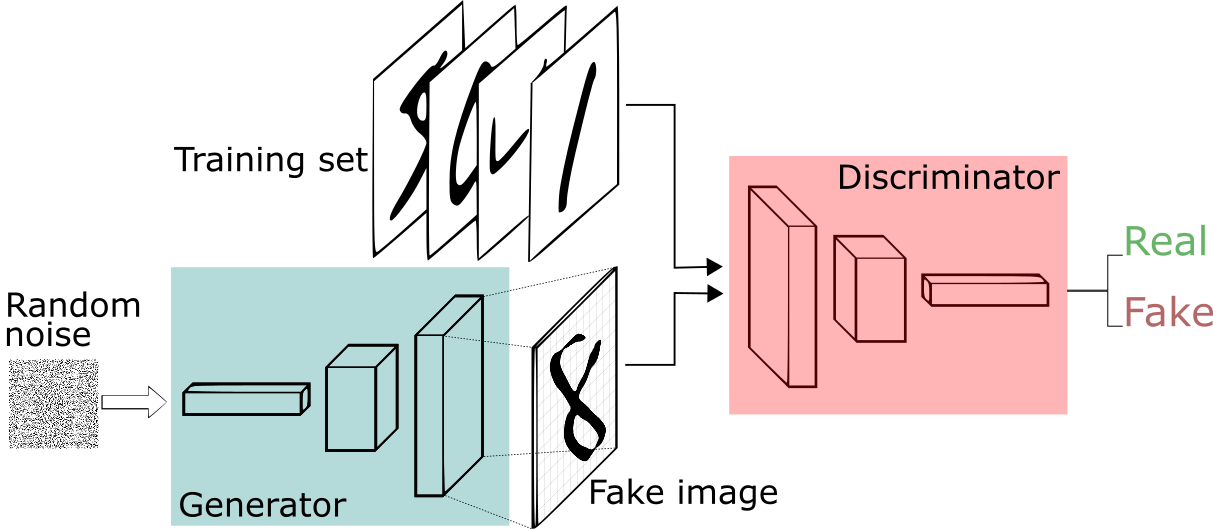

In [1]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [ ]:
device = "cuda"

batch_size=128

noise_dim = 64

lr = 0.002
beta_1 = 0.5
beta_2 = 0.99

epochs = 20

# Load MNIST Dataset

In [ ]:
from torchvision import datasets, transforms as T

In [ ]:
train_augs = T.Compose([
      T.RandomRotation((-20,+20)),
      T.ToTensor()
])

In [ ]:
trainset = datasets.MNIST("MNIST/",download = True, train = True, transform = train_augs)

100%|██████████| 9912422/9912422 [00:00<00:00, 110563114.29it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 122483006.90it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 30688738.69it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22598492.01it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



# Load Dataset Into Batches

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
dataiter = iter(trainloader)
images,_ = next(dataiter)

In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

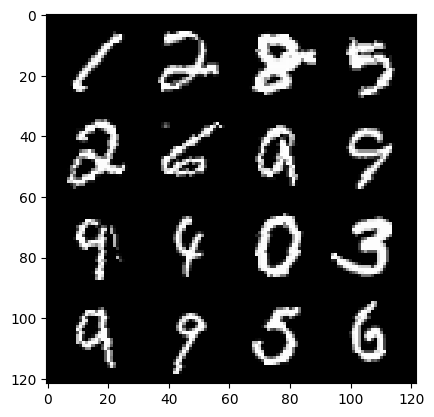

In [ ]:
show_tensor_images(images)

# Create Discriminator Network

In [ ]:
#In case if torch summary is not installed
!pip install torchsummary

In [ ]:
from torchsummary import summary
from torch import nn

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [ ]:
def get_disc_block(in_channels, out_channels,kernel_size,stride):
  return nn.Sequential(
      nn.Conv2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.block_1 = get_disc_block(1,16,(3,3),2)
    self.block_2 = get_disc_block(16,32,(5,5),2)
    self.block_3 = get_disc_block(32,64,(5,5),2)
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features=64,out_features=1)

  def forward(self,images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5


In [ ]:
D = Discriminator()
D.to(device)
summary(D, input_size= (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [ ]:
def get_gen_block(in_channels, out_channels,kernel_size,stride,final_block = False):
  if final_block:
    return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
      nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )


In [ ]:
class Generator(nn.Module):

  def __init__(self,noise_dim):

    super(Generator,self).__init__()
    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim,256,(3,3),2)
    self.block_2 = get_gen_block(256,128,(4,4),1)
    self.block_3 = get_gen_block(128,64,(3,3),2)

    self.block_4 = get_gen_block(64,1,(4,4),2,final_block = True)

  def forward(self,r_noise_vec):

    x= r_noise_vec.view(-1,self.noise_dim,1,1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4

In [ ]:
G = Generator(noise_dim)

G.to(device)

summary(G,input_size = (1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth= torch.ones_like(disc_pred)
  loss = criterion(disc_pred,ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth= torch.zeros_like(disc_pred)
  loss = criterion(disc_pred,ground_truth)
  return loss



In [ ]:
D_opt = torch.optim.Adam(D.parameters(),lr =lr,betas=(beta_1,beta_2))
G_opt = torch.optim.Adam(G.parameters(),lr =lr,betas=(beta_1,beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1 - D_loss : 0.6690241806288518 - G_loss : 0.7508278771249979


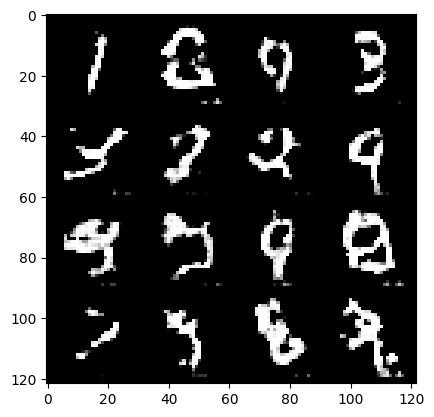

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2 - D_loss : 0.615119192773091 - G_loss : 0.8884359842170276


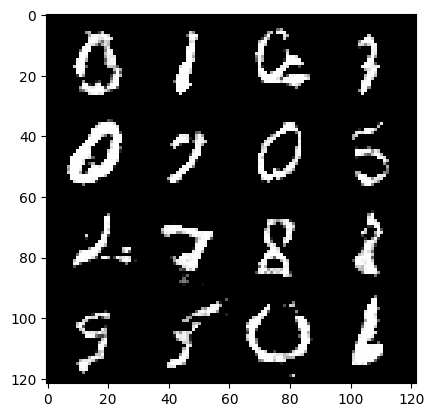

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 3 - D_loss : 0.6156117993631343 - G_loss : 0.9314116585229252


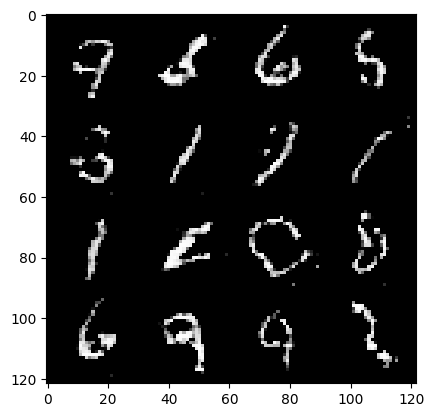

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 4 - D_loss : 0.623352127542882 - G_loss : 0.9198946535968577


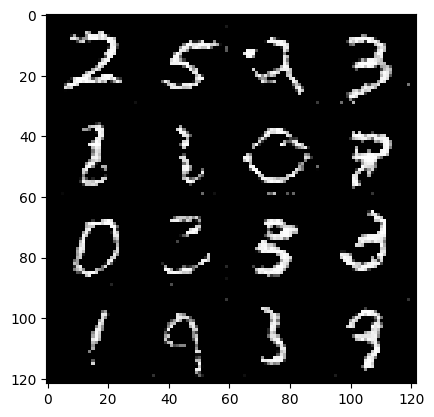

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 5 - D_loss : 0.6315650746766438 - G_loss : 0.9052923728408081


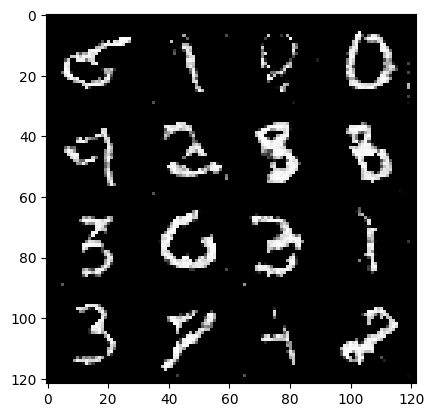

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 6 - D_loss : 0.6295323365532768 - G_loss : 0.9026805862689069


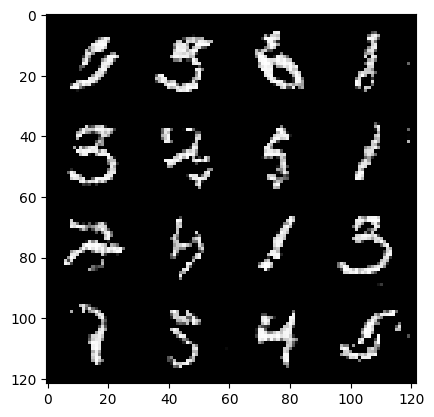

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 7 - D_loss : 0.6253642631746305 - G_loss : 0.9162440992621724


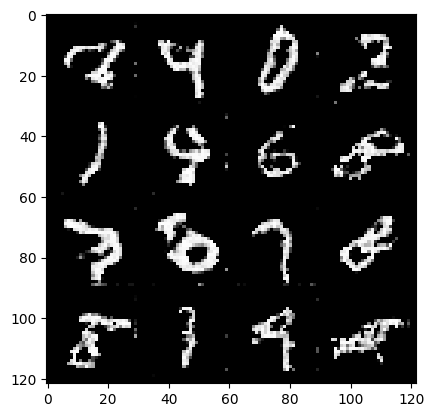

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 8 - D_loss : 0.620207235630133 - G_loss : 0.9378154740404727


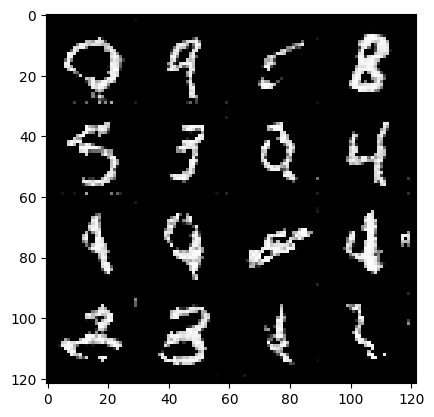

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 9 - D_loss : 0.6133958603273323 - G_loss : 0.954783426927351


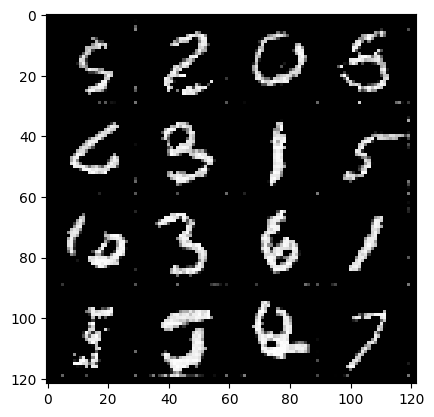

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 10 - D_loss : 0.599971609202021 - G_loss : 0.9918667803695207


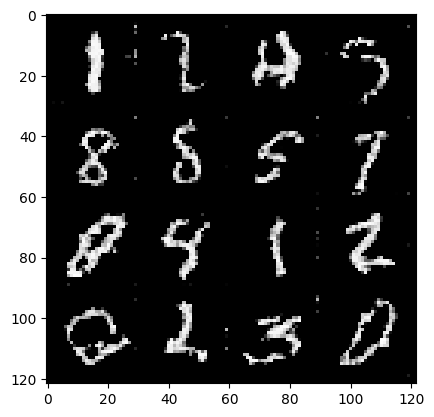

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 11 - D_loss : 0.5842573827009465 - G_loss : 1.030439679556564


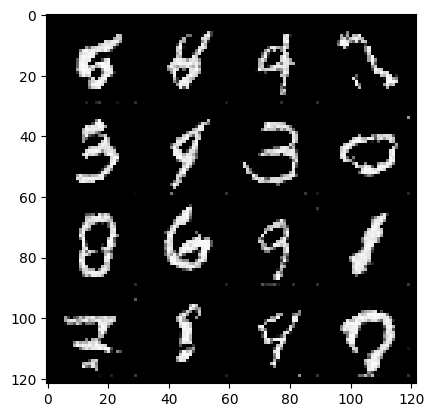

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 12 - D_loss : 0.5672296607163924 - G_loss : 1.0817632766674832


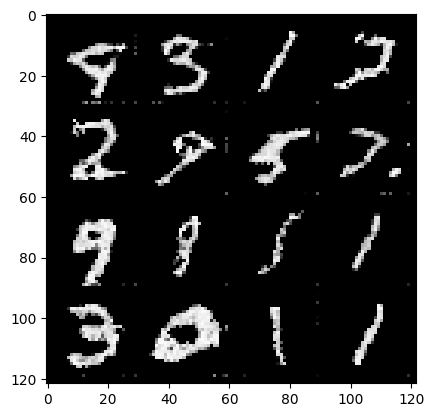

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 13 - D_loss : 0.5604718300833631 - G_loss : 1.115805358012348


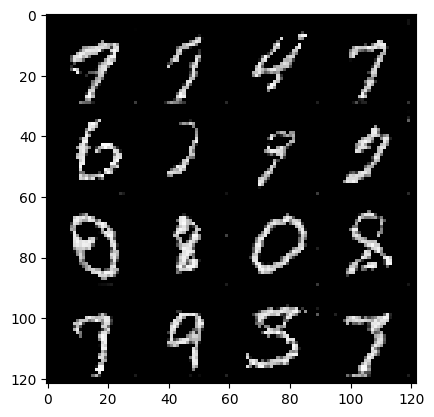

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 14 - D_loss : 0.5623876376192707 - G_loss : 1.1287194140938555


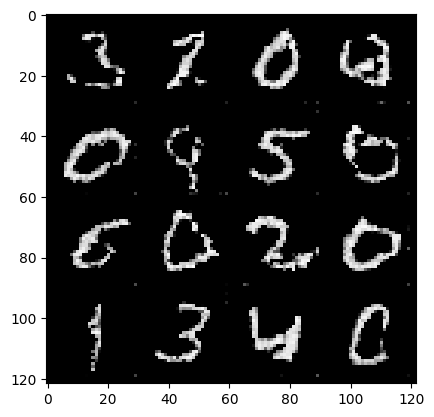

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 15 - D_loss : 0.5555956070102862 - G_loss : 1.140351838394523


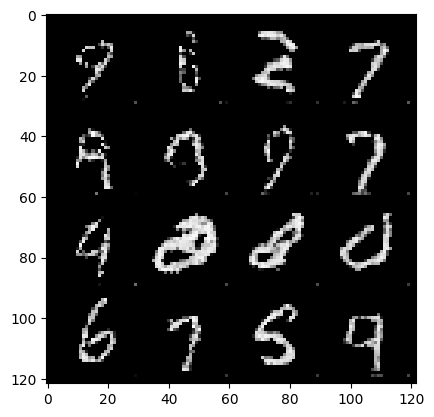

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 16 - D_loss : 0.5576610940732936 - G_loss : 1.1441521916562305


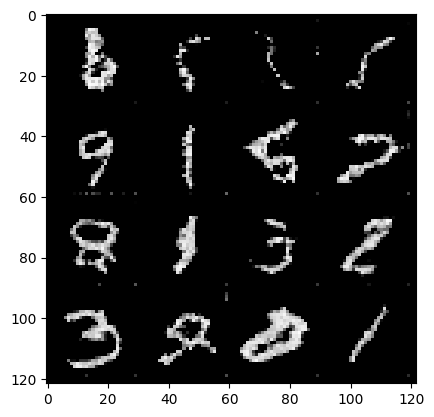

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 17 - D_loss : 0.5603013180974704 - G_loss : 1.1375929259542208


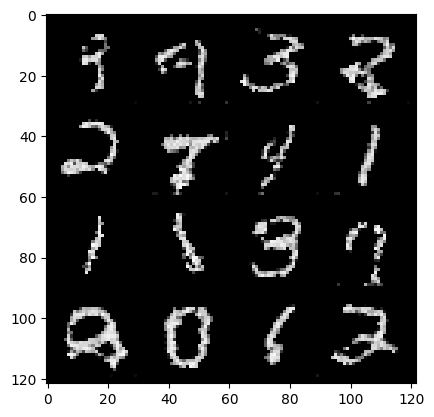

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 18 - D_loss : 0.5581162544582953 - G_loss : 1.1418797070029447


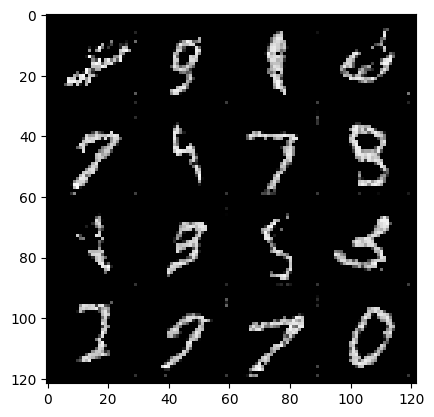

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 19 - D_loss : 0.5619344724648034 - G_loss : 1.1397483855930728


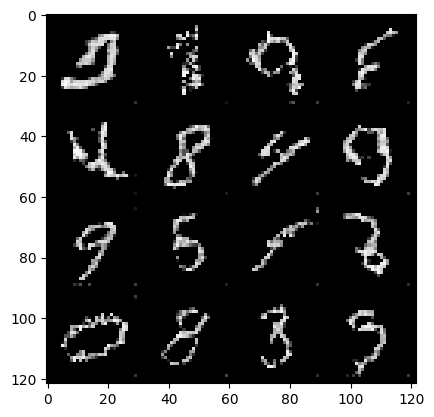

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 20 - D_loss : 0.5630526925200847 - G_loss : 1.1392948918505263


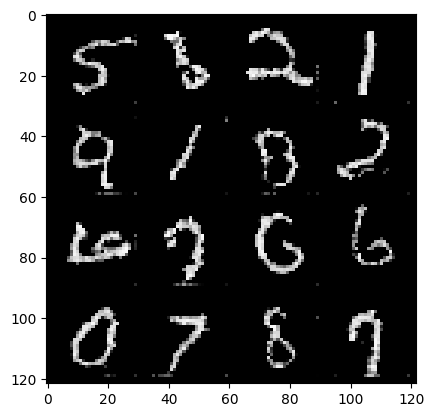

In [ ]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0
  for real_image, _ in tqdm(trainloader):

    real_image = real_image.to(device)

    #Discriminator NN

    D_opt.zero_grad()

    noise = torch.randn(batch_size,noise_dim, device=device)

    fake_image = G(noise)
    D_pred = D(fake_image)
    D_fake_loss =fake_loss(D_pred)

    D_pred = D(real_image)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2

    total_d_loss += D_loss.item()

    D_loss.backward()

    D_opt.step()

    #Generator NN

    G_opt.zero_grad()

    noise = torch.randn(batch_size,noise_dim, device=device)

    fake_image = G(noise)
    D_pred = D(fake_image)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()

    G_opt.step()

  avg_d_loss = total_d_loss/len(trainloader)
  avg_g_loss = total_g_loss/len(trainloader)

  print(f"Epoch : {i+1} - D_loss : {avg_d_loss} - G_loss : {avg_g_loss}")

  show_tensor_images(fake_image)

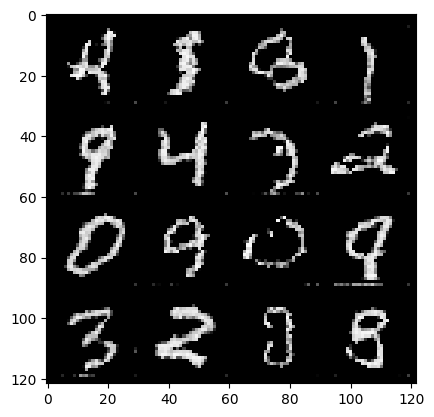

In [ ]:
noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)